# EMA Workbench 101

In this notebook we will shortly demonstrate the basic use of EMA Workbench. Conceptually it has 3 main parts: *Exploratory modeling framework (EM)*, *Connectors*, *Analysis* (read more in the official [docs](https://emaworkbench.readthedocs.io/en/latest/overview.html)), but here we will touch only the first one. The main building blocks of EM are:

<img src="img/em.png">

And a simplifed workflow connected to these building blocks will have only 3 steps:
1. Define the model,
2. Design & run experiments: parameters, outcomes,
3. Analyze the results.

In [1]:
!pip install ema_workbench &> /dev/null

In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import math
from ema_workbench import (Model, RealParameter, ScalarOutcome, ema_logging, perform_experiments)

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

## Step 1. Define the model

The very first step is to define or "load" the model as a function. That is, EMA Workbench treats all models as functions (read *black box*). They are supposed to have **inputs** (parameters, constants, uncertainties and policy levers) and **outputs** (outcomes, KPIs). The model structure is not interesting for EMA Workbench. It may be something simple as `def func(x)` which just returns x + 1.

In [4]:
def ishigami(x1, x2, x3):
    a = 7
    b = 0.05
    return {'y' : math.sin(x1) + \
                  a * math.pow(math.sin(x2), 2) + \
                  b * math.pow(x3, 4) * math.sin(x1)}

## Step 2. Design & run experiments

Now it's time to design experiments. What does it mean? Well, we have to specify:

* **which model parameters** aka *inputs* are we going to sample, what are their **ranges**, and random **distributions**,
* what we will keep as **constants** and do not change over the model run,
* and finally which **outcomes** we want to observe.

It's an important step and we have to be careful. Because if parameter ranges are too narrow or they're sampled from e.g. a Normal distribution, there is a chance that you'll overlook import model behavior. This is why model parameters are named **uncertainties** in the EMA Workbench. We often do not know parameter vales and how to explore many plausible options.

Now let's talk about the "tech" part. First we have to instantiate EMA Workbench's class `Model`. This is how we "connect" it to our Python model. We have to pass it a name and the function that we have defined previously.

In [5]:
model = Model('ishigami', function=ishigami)

Second, let's access the model and write down its attributes. We use `RealParameter` because all our parameters are floats. To specify a parameter we have to pass it a name, left and right boundaries for sampling. Since our model is static and the outcome don't differ over time, we have to call `ScalarOutcome`.

In [6]:
model.uncertainties = [RealParameter("x1", -math.pi, math.pi),
                       RealParameter("x2", -math.pi, math.pi),
                       RealParameter("x3", -math.pi, math.pi)]

model.outcomes = [ScalarOutcome('y')]

Now, we're all set to run the model. The syntax here is pretty straightforward: we call `perform_experiments`, passing it a model instance and specify how many `scenarios` we need. Depending on the number of scenarios EMA Workbench samples the parameters. As a result, the more scenarios you pass, the more parameter combinations you get.

In [7]:
experiments, outcomes = perform_experiments(model, 100)

[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished


## Step 3. Analyze results

As you can see results can be easily decomposed into 2 data structures:
* `experiments` that store all sampled model parameters,
* `outcomes` with model outcomes creatd with these parameters.

Let's preprocess them a bit to plot more easily.

In [8]:
df = pd.concat([pd.DataFrame(outcomes['y'], columns=['y']), experiments], axis=1)

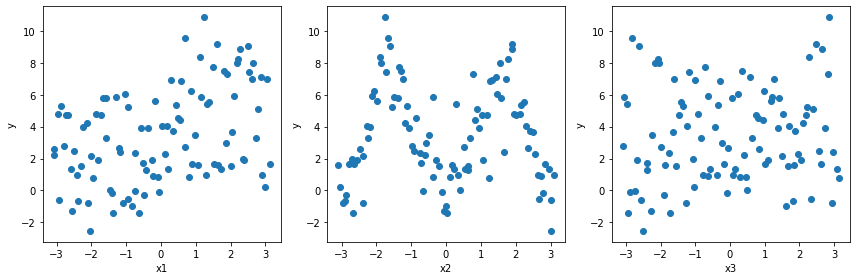

In [9]:
fig, ax = plt.subplots(ncols=3, figsize=(12,4))
for i in range(0, 3):
    ax[i].scatter(df.iloc[:, i+1], df['y'])
    ax[i].set_xlabel(df.iloc[:,i+1].name)
    ax[i].set_ylabel('y')
fig.tight_layout()

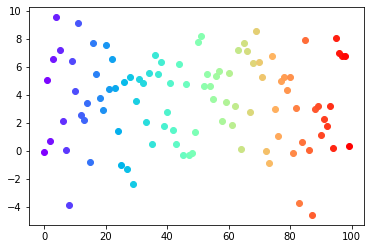

In [7]:
colors = cm.rainbow(np.linspace(0, 1, len(outcomes['y'])))
for i, y, c in zip(np.arange(0, 100), outcomes['y'], colors):
    plt.scatter(i, y, color=c)